In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')
from loadpaths_glc import loadpaths
import data_loading_utils as dlu
import glc_prediction_utils as gpu
path_dict = loadpaths()

In [48]:
dict_dfs, dict_dfs_species, _ = dlu.load_metadata(drop_duplicates=True)

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Dropped 135101/5079797 duplicates in df_train_po_species


In [87]:
dict_dfs['df_train_po']

,lng,lat,year,surveyId
0,1.573057,43.74605,2019,1
1,0.314948,42.12559,2021,2
2,-0.934518,48.29520,2021,3
3,-2.644535,53.63367,2021,4
4,7.925086,49.79471,2021,5
...,...,...,...,...
5079792,5.083568,52.09212,2021,3919658
5079793,11.451360,59.24371,2020,3919659
5079794,4.100798,44.27572,2021,3919660
5079795,8.761634,52.10707,2021,3919661



----
df_train_pa: 88987 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 88987
Unique species: 5016

----
df_train_po: 3845533 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 3845533
Unique species: 9709

----
df_test_pa: 4716 samples
Index(['lng', 'lat', 'year', 'surveyId'], dtype='object')
Unique surveys: 4716
Unique species: NA


/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: us

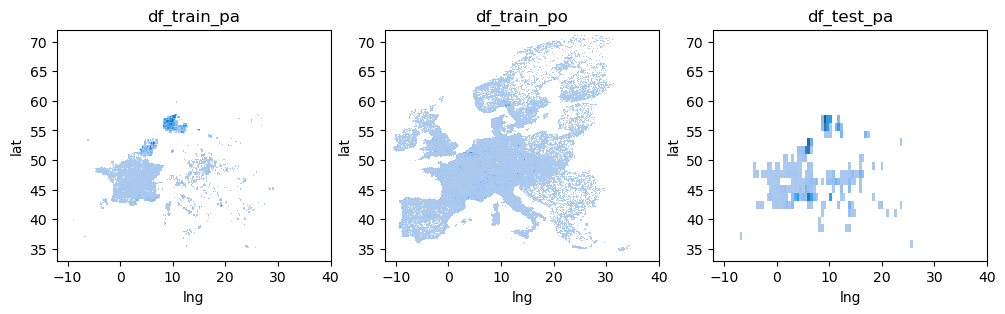

In [4]:
for key, df in dict_dfs.items():
    print('\n----')
    print(f'{key}: {df.shape[0]} samples')
    print(df.columns)
    n_unique_samples = df['surveyId'].nunique()
    if 'test' not in key:
        n_unique_species = dict_dfs_species[key + '_species']['speciesId'].nunique()
    else:
        n_unique_species = 'NA'
    print(f'Unique surveys: {n_unique_samples}')
    print(f'Unique species: {n_unique_species}')

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
# ax = ax.flatten()
for i, key in enumerate(dict_dfs.keys()):
    df = dict_dfs[key]
    sns.histplot(data=df, x='lng', y='lat', ax=ax[i])
    ax[i].set_title(key)
    ax[i].set_xlim([-12, 40])
    ax[i].set_ylim([33, 72])

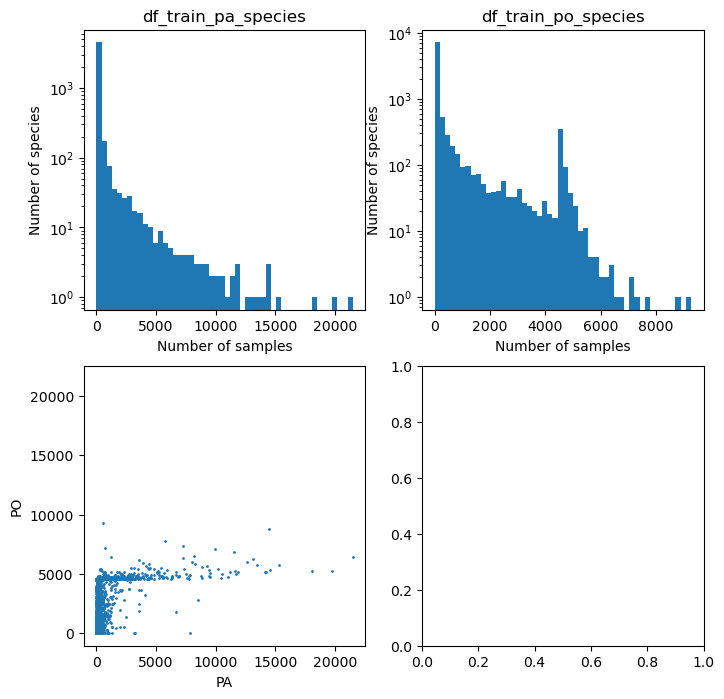

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

for iplot, name in enumerate(['df_train_pa_species', 'df_train_po_species']):
    curr_ax = ax[0, iplot]
    curr_ax.hist(dict_dfs_species[name].value_counts('speciesId').values, bins=50)
    curr_ax.set_yscale('log')
    curr_ax.set_title(name)
    curr_ax.set_xlabel('Number of samples')
    curr_ax.set_ylabel('Number of species')

curr_ax = ax[1, 0]
val_counts_pa = dict_dfs_species['df_train_pa_species'].value_counts('speciesId')
val_counts_po = dict_dfs_species['df_train_po_species'].value_counts('speciesId')
joint_counts_overlap = np.zeros((val_counts_pa.shape[0], 2))
for i, species_id in enumerate(val_counts_pa.index):
    joint_counts_overlap[i, 0] = val_counts_pa[species_id]
    joint_counts_overlap[i, 1] = val_counts_po.get(species_id, 0)

curr_ax.scatter(joint_counts_overlap[:, 0], joint_counts_overlap[:, 1], s=1)
curr_ax.set_xlabel('PA')
curr_ax.set_ylabel('PO')
# curr_ax.set_xlim([-100, 5000])
# curr_ax.set_ylim([-100, 5000])
rfv.equal_xy_lims(curr_ax)

## Thoughts on data:
- *elevation*: clean except 35 surveys -> fixed
- *landcover*: clean, categorical
- *climate_av*: clean, 20 features.
- *climate_monthly*: clean, 4 feat * 12 months * 20 years = 900 features
- *human_footprint*: clean except few cols, can be excluded. 10 features left (5 for 1992, 5 for 2010)
- *soilgrids*: clean except for 7500-9000 surveys. 9 features.
- *landsat timeseries*: clean except for 2018 onwards (can be excluded). 4 quartes * 17 years = 68 features. * 6 bands = 400 features
- *

In [100]:
example_sat_im = dlu.load_sat_patch(surveyId=212)

In [85]:
df_all = dlu.load_multiple_env_raster(mode='train',
    list_env_types=['elevation', 'landcover', 'climate_av', 'landsat'])
df_all

Nans in elevation data: 35. Manually fixing now.
Nans in elevation data fixed


,surveyId,Elevation,LandCover,Bio1,Bio2,Bio3,Bio4,Bio5,Bio6,Bio7,...,2015_3_swir2,2015_4_swir2,2016_1_swir2,2016_2_swir2,2016_3_swir2,2016_4_swir2,2017_1_swir2,2017_2_swir2,2017_3_swir2,2017_4_swir2
0,212,47.0,8.0,2883,68,3,5545,3007,2780,227,...,18.0,10.0,13.0,19.0,18.0,12.0,7.0,15.0,16.0,10.0
1,222,6.0,12.0,2815,59,2,5690,2935,2720,215,...,28.0,26.0,20.0,20.0,30.0,27.0,22.0,23.0,27.0,27.0
2,243,10.0,5.0,2821,26,1,5150,2910,2741,169,...,11.0,11.0,6.0,1.0,8.0,15.0,9.0,10.0,8.0,15.0
3,324,116.0,14.0,2870,90,3,5315,2992,2756,236,...,15.0,38.0,35.0,47.0,17.0,23.0,40.0,42.0,15.0,35.0
4,333,84.0,14.0,2858,81,3,5285,2982,2758,224,...,64.0,42.0,44.0,52.0,32.0,52.0,33.0,57.0,21.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88982,3919553,23.0,12.0,2817,30,1,5398,2913,2734,179,...,21.0,25.0,27.0,29.0,25.0,23.0,29.0,32.0,23.0,21.0
88983,3919592,138.0,1.0,2812,19,1,5540,2909,2734,175,...,14.0,10.0,13.0,16.0,12.0,12.0,9.0,14.0,13.0,11.0
88984,3919620,37.0,12.0,2815,59,2,5564,2931,2722,209,...,25.0,28.0,47.0,36.0,25.0,31.0,35.0,27.0,33.0,27.0
88985,3919640,131.0,1.0,2808,66,2,6775,2945,2693,252,...,11.0,8.0,4.0,11.0,12.0,7.0,5.0,13.0,16.0,7.0


In [98]:
tmp = dlu.create_full_pa_ds(val_or_test='test', transform_pca=True)
tmp[0][0]

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Dropped 135101/5079797 duplicates in df_train_po_species
Nans in elevation data: 35. Manually fixing now.
Nans in elevation data fixed
Nans in elevation data fixed


,lng,lat,year,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,3.099038,43.134956,2021,-4.140852,5.998807,-1.621380,-0.533345,1.153670,0.942994
1,9.884560,56.912140,2017,-0.736499,-1.406413,-0.767088,-0.030611,-0.458917,0.209892
2,8.256020,55.637050,2019,-1.172821,-0.999754,2.375255,1.563494,2.020234,-0.277029
3,-0.402590,43.505630,2018,0.784714,4.917263,0.635829,-2.197963,-1.514304,0.233987
4,-0.517360,45.806430,2017,-0.212238,4.082964,0.439123,-1.449189,-1.204174,0.671149
...,...,...,...,...,...,...,...,...,...
88982,10.327990,57.305850,2018,-1.466621,-2.045692,1.369131,1.144011,-0.172755,-0.281587
88983,15.003900,55.090170,2017,-1.790176,-2.221714,1.014126,0.978319,3.309965,-0.186005
88984,8.935060,55.461500,2018,0.906609,-0.491387,0.689881,0.859048,-0.666737,-0.178513
88985,17.252948,53.901434,2021,0.965344,-1.616726,-3.263385,0.568892,2.252183,-1.459545


In [75]:
import timm 
import torchgeo 
from torchgeo.models import ResNet18_Weights
import torch
weights = ResNet18_Weights.SENTINEL2_RGB_MOCO
print(weights.meta)
model = timm.create_model('resnet18', in_chans=weights.meta['in_chans'], num_classes=16)
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

{'dataset': 'SSL4EO-S12', 'in_chans': 3, 'model': 'resnet18', 'publication': 'https://arxiv.org/abs/2211.07044', 'repo': 'https://github.com/zhu-xlab/SSL4EO-S12', 'ssl_method': 'moco'}


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [76]:
model.forward(torch.tensor(tmp_img).permute(2, 0, 1).unsqueeze(0).float())

tensor([[-0.0099, -0.0224,  0.0190,  0.0753, -0.0348, -0.0110, -0.0119, -0.0232,
          0.0328, -0.0029,  0.0595,  0.0226, -0.0535, -0.0460, -0.0186,  0.0068]],
       grad_fn=<AddmmBackward0>)

In [79]:
weights.SENTINEL2_RGB_MOCO.__dict__

{'_value_': Weights(url='https://hf.co/torchgeo/resnet18_sentinel2_rgb_moco/resolve/e1c032e7785fd0625224cdb6699aa138bb304eec/resnet18_sentinel2_rgb_moco-e3a335e3.pth', transforms=AugmentationSequential(
   (augs): AugmentationSequential(
     (Resize_0): Resize(output_size=256, p=1.0, p_batch=1.0, same_on_batch=True, size=256, side=short, resample=bilinear, align_corners=True, antialias=False)
     (CenterCrop_1): CenterCrop(p=1.0, p_batch=1.0, same_on_batch=True, resample=bilinear, cropping_mode=slice, align_corners=True, size=(224, 224), padding_mode=zeros)
     (Normalize_2): Normalize(p=1.0, p_batch=1.0, same_on_batch=True, mean=0, std=10000)
   )
 ), meta={'dataset': 'SSL4EO-S12', 'in_chans': 3, 'model': 'resnet18', 'publication': 'https://arxiv.org/abs/2211.07044', 'repo': 'https://github.com/zhu-xlab/SSL4EO-S12', 'ssl_method': 'moco'}),
 '_name_': 'SENTINEL2_RGB_MOCO',
 '__objclass__': <enum 'ResNet18_Weights'>}